# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
"""fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1"""

In [ ]:

fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:  # loop through runs
    if not bool(ev):  # empty EV file (e.g. when there were no error trials or no no-response trials)
        frames_list.append(np.array([]))
    else:
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)

        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)

        # Take the range of frames that correspond to this specific trial
        if type(start)==np.ndarray:  # many trials
            frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]  # loop through different onsets for each trial
        elif type(start)==float or type(start)==np.int64:  
            # contains only one onset: it is either the full block (with many trials inside, 
            # but just one onset value) or just a single trial
            frames = [start + np.arange(skip, duration)]
        
        frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data


def get_condition_bold(subject, task, condition, run, task_bold_timeseries):
  """
  Get BOLD signal just for the frames of a specific subject, task and condition

  Args:
    task_bold_timeseries () : BOLD timesires of all frames of a task # load_timeseries(subject, 'wm', runs=None, concat=True, remove_mean=True):

  Returns:
    condition_bold_timeseries (): average BOLD signal across block

  """
  frames = condition_frames(load_evs(subject,task,condition))[run]

  start_idx = frames.min()
  end_idx = frames.max()+1

  condition_bold_timeseries = np.mean(task_bold_timeseries[:,start_idx:end_idx], axis=1)
  return condition_bold_timeseries


def frame_labels(desired_conditions, desired_run, desired_sub):
  """
  To get the frame labels corresponding to a single desired condition, run, and subject

  Args: 
  desired_conditions : list of strings (1 or more) conditions you want the frames for (['0bk_faces', '2bk_faces', '2bk_tools'])
  desired_run : int, 0 or 1
  desired_sub : int, the subject you want

  Returns:
  a dict with the frames corresponding to each condition.
  """
  frm_dict={key: [] for key in desired_conditions}
  #get the frames for all the conditions
  for condition in desired_conditions:
    e=load_evs(name="wm", condition=condition,subject=desired_sub)
    frms = condition_frames(e, skip=0)[desired_run]
    frm_dict[condition] = frms
  return frm_dict



## Create dataframe from *EVs*

In [ ]:
def frames_df(task, conditions):
    """ Create data frame in which each row describes the ev 
    subject, run, task, condition, and frames
    
    Args:
    task: 'wm' in our case
    conditions: can be a single string or list of strings with which conditions to 
        include in dataframe (e.g. ['0bk_faces', '2bk_faces', '0bk_err'])
    
    Returns:
        frames_df (pandas DataFrame): has one column with lists of frames
    """
    
    frames_df=pd.DataFrame([])

    for subject in subjects:
        for condition in conditions:
            evs = load_evs(subject, task, condition)
            df = pd.DataFrame(evs) # load evs into df
            df['run']= [0,1] 
            df['subject'] = subject
            df['condition'] = condition
            df['frames'] = condition_frames(evs)
            frames_df = frames_df.append(df, ignore_index=True)
        
    return frames_df

## Create dataframe for timeseries

In [ ]:
def TS_df(run, subject,task='wm'):
  """ Create data frame for 1 run, 1 subject
    
    Args:
    task: 'wm' in our case
    run: 0 or 1
    
    Returns:
        bold_df (pandas DataFrame): each row is the fMRI measure for 1 frame
                                    columns are the subjects.
    """
  T = load_timeseries(subject, task, runs=run, concat=True, remove_mean=True)
  #  bold1 = get_condition_bold(subject, task, condition, run, T)
  df = pd.DataFrame(T.T) # makes it so that there are 405 rows and 360 cols
  df.columns=['Region {}'.format(i) for i in range (0, 360)]
  df.index = ['Frame {}'.format(i) for i in range (0, 405)]
  return df
  #  bold = get_condition_bold(subject, task, condition, run, task_bold_timeseries)

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err

```

# PCA

(360, 405)

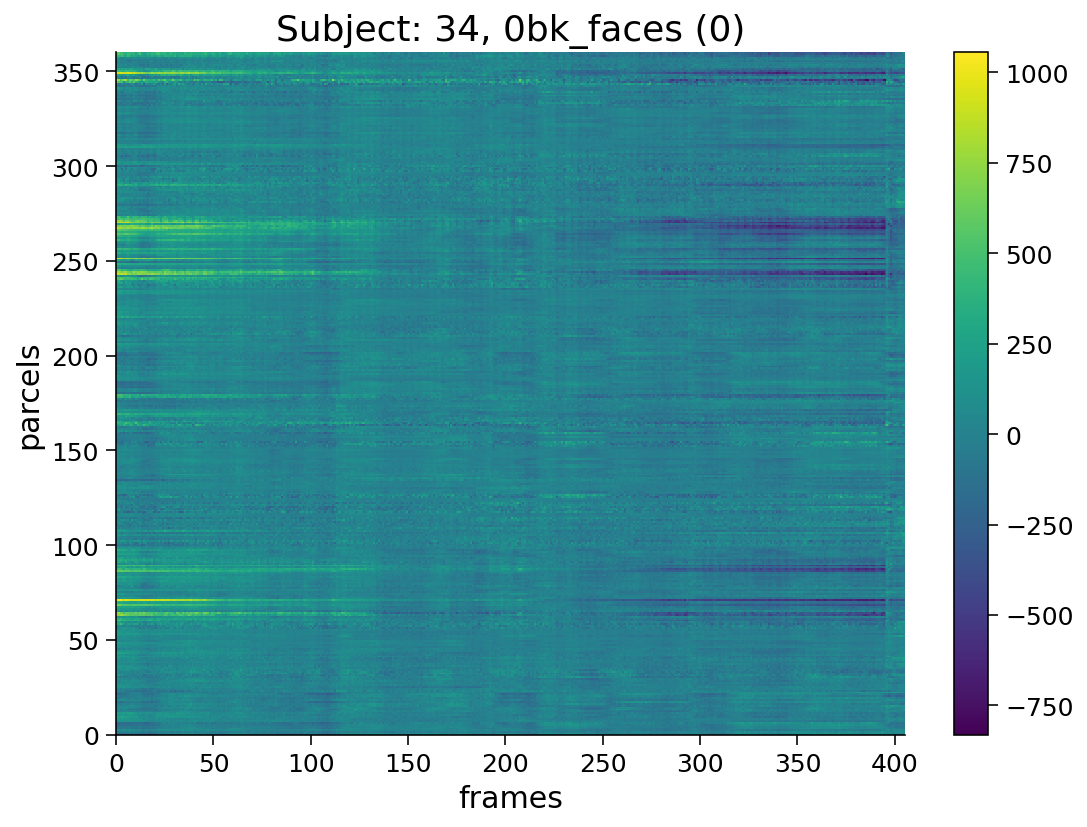

In [ ]:
# Visualize one subject for each condition

SUBJ = 34
cond = "0bk_faces"
run_num = 0

ts = load_timeseries(subject=SUBJ, name="wm", runs=run_num)

faces_0bk = get_condition_bold(subject=SUBJ,task='wm',condition=cond, run=run_num, task_bold_timeseries=ts)


faces_0bk.shape
ts.shape
ts[0].shape

plt.figure()
plt.pcolormesh(ts)
plt.colorbar()
plt.xlabel("frames")
plt.ylabel("parcels")
plt.title("Subject: {}, {} ({})".format(SUBJ, cond, run_num))

#access columns by [:, x]

fr_0 = ts[:, 0]

np.shape(ts)


In [ ]:
#load the data for the first subject
ts_matrix_0 = TS_df(run=0, subject=0)
ts_matrix_0.head()

#Get the  covariance matrix + eigenvalues /eigenvectors 
X = np.matrix(ts_matrix_0)
X = StandardScaler().fit_transform(X)

X_covar = np.cov(X, rowvar=False) # rowvar=false because each row is a timepoint, and the COLUMNS are the observations for the timepoints
evals, evecs = np.linalg.eig(X_covar) 
#tuples to keep the evals/evecs corresponding together
eig_pairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

ts_matrix_0['lab']=np.nan



In [ ]:
#get the labels onto the dataframe:


all_conds = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']

labels = frame_labels(desired_conditions=all_conds, desired_run=0, desired_sub=0) 



for key, value in labels.items():
  for fr in value:
   # ts_matrix_0.iloc[(fr-1)] = key
 #   print(key)
   # ts_matrix_0.at[,'lab'] = key
    ts_matrix_0.iloc[(fr), ts_matrix_0.columns.get_loc('lab')] = key
    



ts_matrix_0.head()


,Region 0,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9,Region 10,Region 11,Region 12,Region 13,Region 14,Region 15,Region 16,Region 17,Region 18,Region 19,Region 20,Region 21,Region 22,Region 23,Region 24,Region 25,Region 26,Region 27,Region 28,Region 29,Region 30,Region 31,Region 32,Region 33,Region 34,Region 35,Region 36,Region 37,Region 38,Region 39,...,Region 321,Region 322,Region 323,Region 324,Region 325,Region 326,Region 327,Region 328,Region 329,Region 330,Region 331,Region 332,Region 333,Region 334,Region 335,Region 336,Region 337,Region 338,Region 339,Region 340,Region 341,Region 342,Region 343,Region 344,Region 345,Region 346,Region 347,Region 348,Region 349,Region 350,Region 351,Region 352,Region 353,Region 354,Region 355,Region 356,Region 357,Region 358,Region 359,lab
Frame 0,-16.919012,63.30716,175.833827,23.231605,-7.988148,-90.379753,-88.09679,26.687086,157.257086,57.911358,54.537679,-18.274889,39.769136,217.510123,40.244444,84.883457,110.223951,-40.355556,29.20963,-14.90,-98.982963,-117.815506,31.614469,31.519012,-60.844815,54.788395,31.258272,15.727852,101.931852,140.137778,166.594321,253.478272,136.244198,361.020247,113.656543,43.538963,-4.111358,116.988889,-25.522519,65.252346,...,134.306914,75.401481,105.341333,116.276049,177.569877,-66.250815,-14.869037,72.013852,137.976049,135.629383,244.886173,166.674321,-79.23679,-31.315556,37.210099,-64.786173,-20.118025,58.034568,98.704198,180.541481,273.612346,-7.16963,372.046099,356.99037,-168.042395,73.645432,-18.964938,20.782716,233.028889,125.590864,-22.089926,-35.197284,-22.777778,-21.911753,152.583951,-35.033407,137.839012,53.997531,-86.746914,NaN
Frame 1,-53.119012,26.30716,72.733827,-35.268395,-11.588148,-83.179753,-138.79679,-8.522914,123.287086,-8.428642,40.217679,1.195111,-7.130864,172.810123,-51.955556,35.683457,34.923951,-69.755556,-3.09037,-31.30,-11.992963,-42.775506,-45.845531,-92.980988,-57.334815,-4.811605,100.458272,11.367852,53.831852,109.637778,102.094321,170.178272,72.644198,272.720247,97.456543,21.948963,10.388642,46.488889,-27.522519,32.952346,...,132.506914,68.001481,40.971333,59.976049,46.369877,-61.720815,-11.799037,59.413852,104.876049,111.529383,203.086173,-2.925679,-76.13679,100.184444,24.920099,-66.286173,-21.418025,-17.665432,-89.295802,72.141481,197.012346,39.73037,141.776099,248.09037,-3.242395,35.245432,41.135062,10.282716,296.128889,11.090864,-72.359926,-30.297284,-64.177778,15.378247,103.683951,-25.673407,59.639012,-16.202469,-113.346914,NaN
Frame 2,-54.619012,45.30716,65.233827,-0.268395,-55.388148,-107.679753,-186.29679,-13.272914,72.167086,-21.928642,100.137679,-14.564889,45.569136,224.010123,-29.155556,19.283457,43.023951,-66.155556,6.30963,-14.10,-48.852963,-99.635506,-18.855531,-0.780988,-8.414815,-36.711605,93.558272,-19.412148,78.731852,140.537778,119.594321,40.478272,42.844198,320.920247,106.056543,86.068963,30.488642,59.788889,-42.252519,48.452346,...,89.006914,48.101481,63.791333,23.476049,81.069877,-19.480815,-14.659037,52.593852,70.776049,93.729383,133.186173,-104.225679,67.06321,12.984444,-90.699901,-70.286173,-20.118025,-4.365432,-77.695802,80.241481,179.212346,-22.86963,220.796099,296.79037,-237.312395,-19.054568,49.035062,-56.417284,166.528889,29.890864,-82.789926,-53.197284,-79.177778,10.718247,112.883951,-4.383407,53.939012,-79.102469,-129.446914,NaN
Frame 3,-63.219012,-15.49284,29.933827,-97.468395,-55.988148,-134.379753,-222.29679,-2.912914,58.387086,-32.728642,17.277679,-39.224889,-3.730864,198.410123,-14.955556,53.583457,35.723951,-57.255556,-47.39037,-98.92,-92.182963,-135.535506,-55.485531,-16.680988,-40.954815,1.588395,52.358272,45.437852,33.231852,26.137778,77.394321,154.578272,111.944198,382.520247,149.856543,32.288963,15.288642,24.788889,-63.592519,-11.847654,...,45.306914,29.501481,22.291333,49.176049,13.369877,-9.150815,-9.589037,49.673852,54.576049,67.229383,42.886173,-83.125679,36.96321,39.284444,-92.399901,-100.486173,-65.318025,1.334568,-165.995802,-16.958519,

In [ ]:
#drop where the label is NaN (aka this is a fixation point or something)
ts_matrix_0.dropna(subset=['lab'], inplace=True)
ts_matrix_0

,Region 0,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9,Region 10,Region 11,Region 12,Region 13,Region 14,Region 15,Region 16,Region 17,Region 18,Region 19,Region 20,Region 21,Region 22,Region 23,Region 24,Region 25,Region 26,Region 27,Region 28,Region 29,Region 30,Region 31,Region 32,Region 33,Region 34,Region 35,Region 36,Region 37,Region 38,Region 39,...,Region 321,Region 322,Region 323,Region 324,Region 325,Region 326,Region 327,Region 328,Region 329,Region 330,Region 331,Region 332,Region 333,Region 334,Region 335,Region 336,Region 337,Region 338,Region 339,Region 340,Region 341,Region 342,Region 343,Region 344,Region 345,Region 346,Region 347,Region 348,Region 349,Region 350,Region 351,Region 352,Region 353,Region 354,Region 355,Region 356,Region 357,Region 358,Region 359,lab
Frame 11,-108.519012,113.20716,49.633827,-56.068395,-51.088148,-47.579753,-131.39679,-0.672914,36.597086,-62.048642,42.447679,36.415111,5.169136,183.110123,-146.855556,84.183457,44.823951,31.244444,34.60963,110.20,-17.072963,-7.165506,62.294469,28.719012,43.875185,-46.111605,-50.141728,30.957852,-81.668148,-32.562222,-38.505679,-44.721728,45.244198,47.920247,-111.243457,110.988963,21.088642,-22.411111,-32.542519,28.052346,...,79.106914,-45.698519,-37.648667,-53.323951,-9.930123,15.439185,-47.979037,-77.036148,-14.423951,-69.670617,41.286173,-47.425679,70.76321,-38.215556,33.590099,-72.286173,-32.318025,28.334568,123.104198,47.041481,74.912346,15.63037,353.996099,459.29037,-209.402395,16.445432,-163.064938,-41.617284,-33.371111,-105.109136,-6.139926,-17.097284,-6.177778,-30.131753,120.583951,-55.063407,79.739012,-50.302469,-182.546914,2bk_body
Frame 12,-130.319012,69.80716,58.733827,-54.068395,-77.288148,-55.579753,-128.99679,13.117086,35.807086,-17.018642,107.247679,10.715111,5.069136,26.010123,-181.555556,102.783457,25.623951,-65.655556,-7.89037,136.70,-13.922963,-33.855506,5.294469,-40.580988,32.225185,-3.011605,0.558272,-18.532148,-123.468148,-86.862222,-48.705679,78.378272,28.544198,135.020247,-88.943457,71.448963,9.388642,-6.511111,-8.792519,8.852346,...,62.806914,-37.198519,-30.968667,-106.023951,48.569877,-5.560815,-48.219037,-69.236148,-12.023951,-71.270617,85.086173,-84.925679,86.26321,28.484444,-12.639901,-25.686173,-40.718025,3.934568,27.804198,4.241481,19.912346,-96.56963,258.356099,72.69037,177.137605,84.145432,19.035062,-12.017284,-22.971111,-172.409136,-24.009926,13.802716,-0.577778,-52.111753,114.483951,-96.573407,154.739012,-110.602469,-150.346914,2bk_body
Frame 13,-116.919012,125.60716,21.133827,-22.168395,-37.788148,-36.679753,-266.39679,-30.852914,93.167086,32.781358,0.097679,31.195111,1.969136,51.610123,-185.455556,-8.616543,65.123951,-57.755556,27.40963,139.00,24.947037,-27.315506,67.154469,3.719012,-0.174815,4.188395,-34.541728,-23.452148,-106.968148,-100.562222,-60.105679,-114.321728,171.344198,34.720247,-150.043457,42.918963,-12.511358,-44.411111,-75.182519,4.252346,...,24.506914,-31.298519,-57.048667,-134.823951,-18.330123,18.659185,-59.389037,-63.586148,0.676049,-50.870617,191.186173,50.674321,10.86321,49.984444,72.150099,-68.886173,-4.718025,34.334568,34.804198,34.441481,29.112346,-22.76963,198.686099,131.49037,190.617605,65.745432,109.635062,-10.717284,45.228889,-189.109136,0.430074,31.402716,-46.277778,-48.631753,78.383951,-51.393407,45.139012,-130.702469,-178.246914,2bk_body
Frame 14,-132.319012,126.00716,0.333827,-63.668395,-53.788148,-46.779753,-94.69679,2.547086,44.847086,-25.878642,-10.502321,-26.684889,-2.330864,8.010123,-125.555556,57.683457,27.423951,-64.955556,28.00963,109.90,-23.182963,-76.835506,72.094469,-13.780988,10.935185,8.588395,-22.641728,5.917852,-140.768148,-133.862222,0.994321,10.478272,60.544198,26.320247,28.656543,23.068963,16.588642,-44.711111,-62.852519,-11.747654,...,49.806914,-44.998519,-95.248667,-96.123951,17.469877,-62.210815,-44.999037,-61.386148,1.676049,-48.870617,102.986173,-33.325679,54.36321,-72.615556,28.230099,-95.786173,-43.118025,-62.565432,-162.

In [ ]:
#Get the  covariance matrix + eigenvalues /eigenvectors 
X = np.matrix(ts_matrix_0.loc[:, ['Region {}'.format(i) for i in range(0, 360)]])
X = StandardScaler().fit_transform(X)

X_covar = np.cov(X, rowvar=False) # rowvar=false because each row is a timepoint, and the COLUMNS are the observations for the timepoints
evals, evecs = np.linalg.eig(X_covar) 
#tuples to keep the evals/evecs corresponding together
eig_pairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)


In [ ]:
# plot the eigenvalues as is
plt.plot(evals);

In [ ]:
# sort high to low and re-plot
evals_sort = -np.sort(-evals)
plt.plot(evals_sort);

In [ ]:
# get variance explained, plot cumulative total

total = sum(evals)
var_exp = [(i / total)*100 for i in evals_sort]
cum_var_exp = np.cumsum(var_exp)

plt.plot(cum_var_exp);

cum_var_exp[5]


In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(16, 8))

    plt.bar(range(360), var_exp, align='center',label='individual explained variance')
    plt.step(range(360), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
# take the first 6 PCs and see how it goes (explains ~63% of variance) - 80% (50 pc) is good but 66 also ok (6 pc only)
N_COMPS=6
pca = PCA(n_components=N_COMPS)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC{}'.format(i) for i in range(0,N_COMPS)])

label_col = ts_matrix_0.loc[:,'lab']

principalDf.reset_index(drop=True, inplace=True)
label_col.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf,label_col],axis=1,ignore_index=True)

finalDf





,0,1,2,3,4,5,6
0,0.558962,10.169045,-0.572122,1.126866,0.247165,-4.362459,2bk_body
1,3.599077,11.738324,0.206572,1.406763,0.921927,-5.256533,2bk_body
2,2.728908,12.829440,1.274064,-0.074682,0.319035,-3.909087,2bk_body
3,3.936166,11.136927,2.621444,2.324265,0.511718,-5.562235,2bk_body
4,3.692744,10.053189,0.352002,2.130395,0.846057,-7.022274,2bk_body
...,...,...,...,...,...,...,...
307,-8.010017,1.408889,-4.922752,1.649501,4.503078,9.657244,2bk_places
308,-6.821510,1.718431,-5.742867,0.582611,5.723932,9.793566,2bk_places
309,-5.045650,-0.293045,-5.212915,-0.793458,4.515163,7.588269,2bk_places
310,3.836048,-0.832651,-4.670816,-1.849194,4.219328,5.375576,2bk_places


# Plotting the first 2 PCs

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

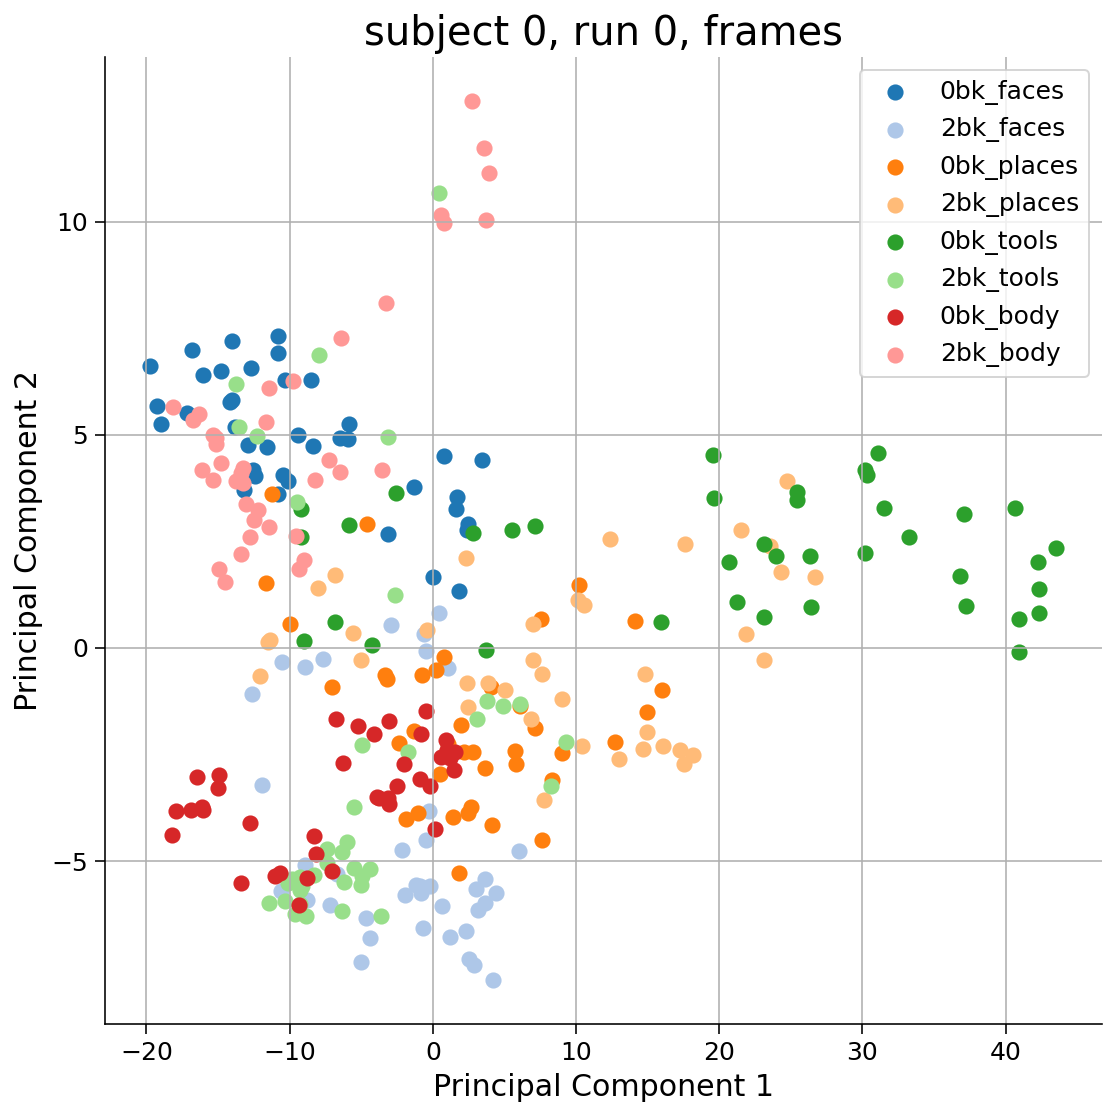

In [ ]:
cmap=plt.cm.get_cmap(plt.cm.tab20,400)
n=1
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('subject 0, run 0, frames', fontsize = 20)
targets = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']
#colors = ['r', 'g', 'b', 'c', 'y', 'm']
for i, target in enumerate(targets):
    indicesToKeep = finalDf[6] == target
    ax.scatter(finalDf.loc[indicesToKeep, 0]
               , finalDf.loc[indicesToKeep, 1]
               , c = cmap(n*i)
               , s = 50);
ax.legend(targets);
ax.grid()
images_dir = '/content/gdrive/My Drive/nma-project-local'
#plt.savefig(f"{images_dir}/subj0_2d_final.png")

# 3d plotting

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

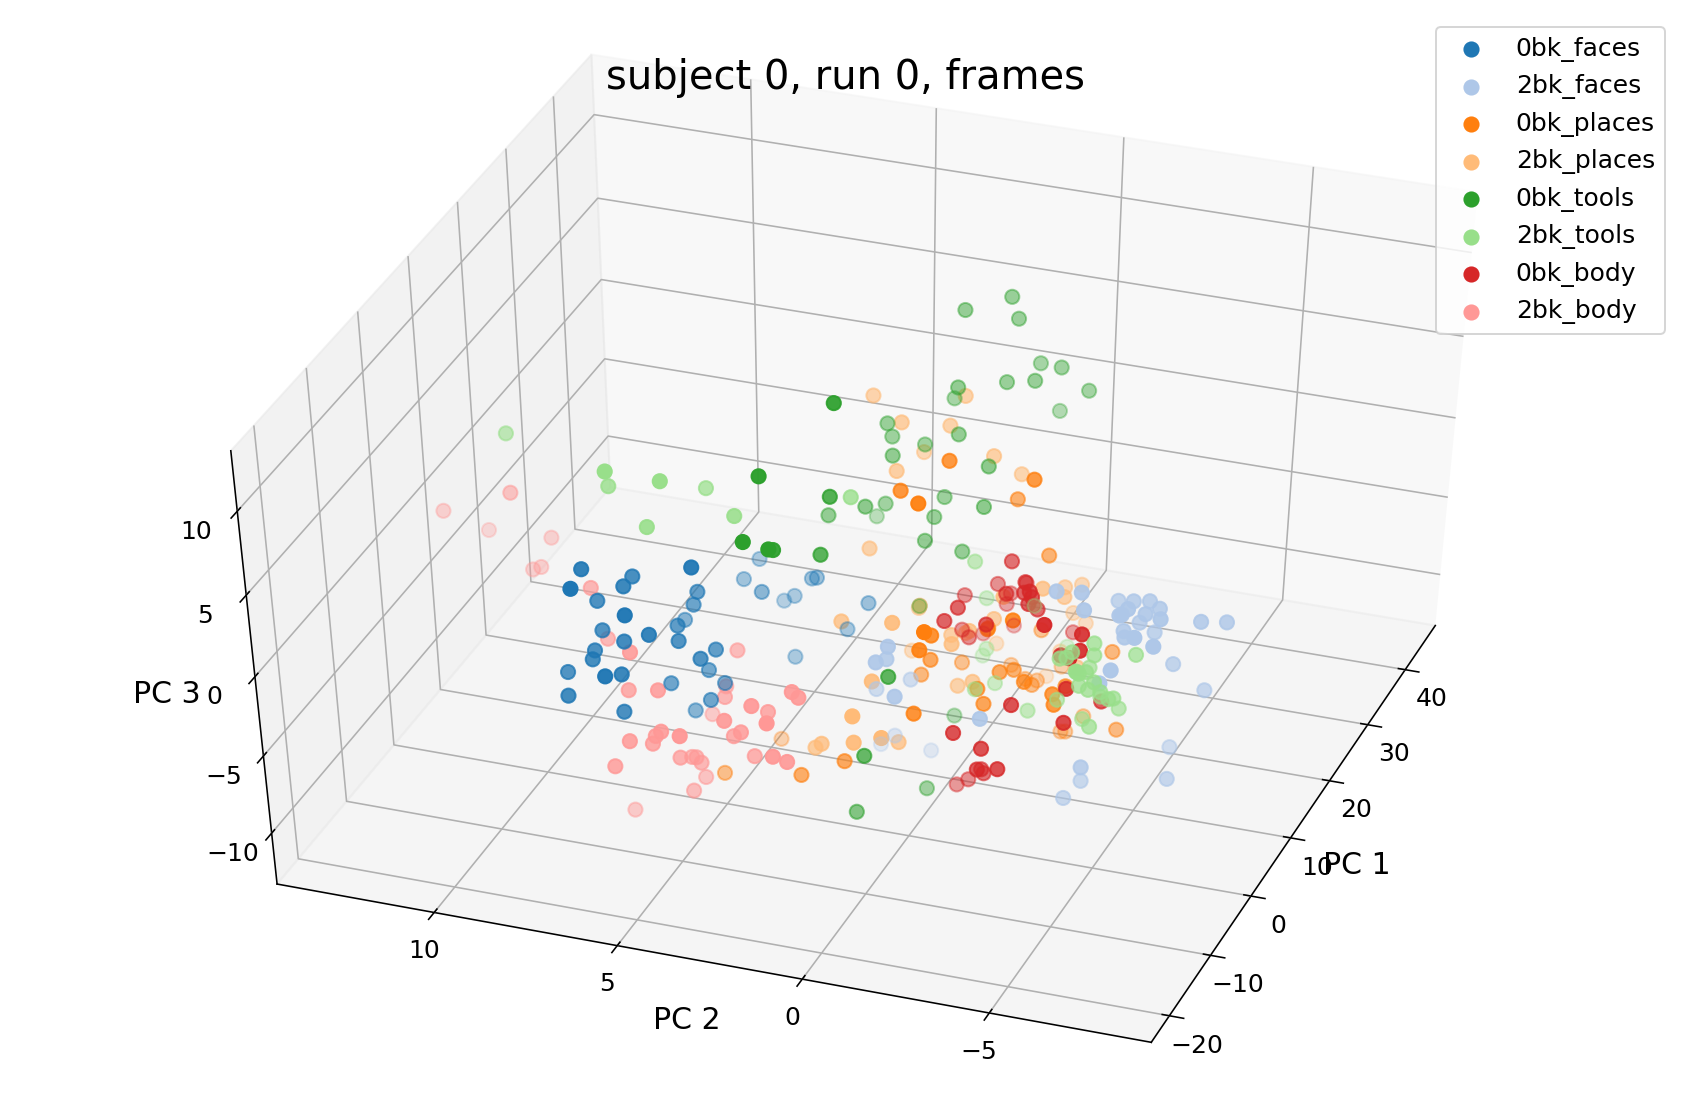

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
targets = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for i, target in enumerate(targets):
    indicesToKeep = finalDf[6] == target
    ax.scatter(finalDf.loc[indicesToKeep, 0]
               , finalDf.loc[indicesToKeep, 1]
               , finalDf.loc[indicesToKeep, 2]
               , c = cmap(i)
               , s = 50);
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('subject 0, run 0, frames', fontsize = 20)
ax.view_init(45, 200)
ax.legend(targets);
images_dir = '/content/gdrive/My Drive/nma-project-local'
#plt.savefig(f"{images_dir}/subj0_3d_FINAL.png")


## Multi_Subject PCA (REAL SECTION)

*   List item
*   List item







In [ ]:
#load the data for all the subjects
subjects_df = pd.DataFrame()


all_conds = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']

for subj in subjects:
    # get timeseries dataframe for a subject
    df = TS_df(run=0, subject=subj)
    df = df.apply(lambda x: x-df.mean(axis=1)) # need to subtract mean of each row before PCA
    df=df.assign(labs="")
    
    # get frames corresponding to each subject
    labels = frame_labels(desired_conditions=all_conds, desired_run=0, desired_sub=subj) 
    
    # assign each row (frame) a label corresponding to the condition (e.g. '2bk_faces', etc.)
    for k,v in labels.items():
        for frame in v:
            df.at['Frame {}'.format(frame),'labs']=k
#             df['label_num'] = pd.Categorical(df['labs']).codes
        
    df.replace('', np.nan, inplace=True)
    df.dropna(subset=['labs'],inplace=True) # keep only frames with labels
    subjects_df = subjects_df.append(df)

    subjects_df.head()

In [ ]:
#Get the covariance matrix + eigenvalues /eigenvectors 
X_all = np.matrix(subjects_df.loc[:, ['Region {}'.format(i) for i in range(0, 360)]])
#X_all = StandardScaler().fit_transform(X_all)



In [ ]:

X_covar_all = np.cov(X_all, rowvar=False) # rowvar=false because each row is a timepoint, and the COLUMNS are the observations for the timepoints
evals_all, evecs_all = np.linalg.eig(X_covar_all) 
#tuples to keep the evals/evecs corresponding together
eig_pairs_all = [(np.abs(evals_all[i]), evecs_all[:,i]) for i in range(len(evals_all))]
eig_pairs_all.sort(key=lambda x: x[0], reverse=True)

N_COMPS=50
pca_all = PCA(n_components=N_COMPS)
principalComponents_all = pca_all.fit_transform(X_all)

principalDf_all = pd.DataFrame(data=principalComponents_all, columns=['PC{}'.format(i) for i in range(0,N_COMPS)])

label_col_all = subjects_df.loc[:,'labs']

principalDf_all.reset_index(drop=True, inplace=True)
label_col_all.reset_index(drop=True, inplace=True)

finalDf_all = pd.concat([principalDf_all,label_col_all],axis=1,ignore_index=True)






,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,-66.014096,444.308279,-384.697242,475.330631,-201.879059,-87.854854,-100.280639,340.407830,122.945827,114.616365,-140.246324,-107.788293,153.877888,60.872106,236.595936,69.690564,-70.353494,-224.682116,-25.290871,-145.202563,190.220369,93.142429,123.557761,-57.405673,162.195990,79.789120,9.758839,-172.212156,-60.322046,-71.304359,-102.487928,-53.208078,-21.702489,-89.729548,68.225506,99.501795,-76.983759,-139.998198,19.159449,157.789786,111.060373,64.778906,67.381335,-42.621501,73.002021,-24.191930,42.578232,-87.221832,3.656164,35.884841,2bk_body
1,244.062162,288.073457,-571.281575,503.317934,38.363647,74.286489,-69.551091,147.564892,152.332232,-106.777544,-89.397896,-209.609728,210.439961,37.199566,78.368552,15.422037,9.248462,77.489511,41.325882,186.472084,106.485394,160.444262,-49.907501,-192.259062,145.358990,238.410354,-34.651326,-84.712005,-116.356370,-102.890348,-180.212366,58.497548,50.912125,-140.218718,126.140727,52.541728,-33.567262,-96.610396,106.050789,63.155244,95.216433,-18.056030,-65.831537,60.784527,82.282224,108.733510,112.101566,-40.668821,79.634423,101.532720,2bk_body
2,13.973114,175.530247,-535.463292,575.340521,-48.866779,76.912805,23.466584,1.672022,184.759380,-108.114249,12.284818,-173.664044,65.977976,30.239802,163.452810,113.766663,70.594397,-101.527951,-4.675978,32.485424,-51.245570,124.375773,-20.462561,-51.425332,244.133061,-3.854968,-255.697477,-59.980854,-96.927802,-10.220414,-195.977864,-32.680003,-76.164024,19.949886,11.569258,118.690035,19.576738,-65.041684,47.361345,36.358019,-13.205040,6.870088,116.678818,81.478589,74.116331,-97.328354,181.237359,-130.960423,44.261078,36.358307,2bk_body
3,280.165297,378.121724,-350.061838,478.191140,88.603639,72.474823,29.726326,2.605029,66.460330,-126.239132,53.893591,-31.975252,-77.325105,-120.007555,317.360690,257.559218,54.227073,-154.323176,153.860839,224.048051,-16.692999,96.645107,140.699998,43.608582,159.166745,-46.921929,31.872278,-143.543361,23.757233,-166.930969,-82.022475,-41.559713,32.545934,-45.479691,99.456946,30.698362,-98.846421,-107.515656,-14.314145,81.997124,36.995091,114.872857,14.872899,-31.280625,8.877224,54.103072,55.497976,-148.629911,49.268188,96.935239,2bk_body
4,205.262965,335.475794,-267.775244,581.765917,-202.580145,-155.699909,-6.464535,291.635033,41.824309,71.398029,-273.084773,-157.787514,104.672139,-44.028980,-162.068183,145.708181,81.090881,-59.269134,103.365486,32.877909,-14.632095,101.130681,65.733200,-67.183720,162.217904,104.444798,118.380324,32.755790,-37.568950,-82.812684,-53.941578,-72.205972,22.860200,27.129956,-29.673051,44.199866,-31.171275,50.727346,-61.845894,233.947543,-20.003594,35.814510,39.590256,-2.057375,79.904409,51.258946,27.719668,69.058735,54.144762,74.192863,2bk_body
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105763,-505.161722,292.074970,94.909002,-323.459209,198.098985,95.476177,15.298177,-8.462056,-104.422269,53.647143,-142.966940,-4.700649,-37.356873,-7.038362,-169.299574,-205.330932,-32.339152,159.881821,231.673914,-39.935719,186.430824,119.979805,102.276860,-183.840445,60.727161,92.487095,68.002616,-69.236596,20.516839,-46.321256,76.001790,98.174688,0.296972,-15.920257,-188.345825,176.701120,80.186556,108.496555,-22.033903,141.149154,6.457073,-124.044607,-25.185420,61.219731,-108.750046,-158.525349,94.055782,-15.737844,202.858292,42.113591,2bk_places
105764,-340.415923,331.137095,-47.448023,-397.565042,183.998388,85.919313,-128.530499,41.373746,-6.607456,115.511309,-201.831387,35.551704,-111.097365,68.646024,116.156544,-263.686007,179.765491,166.424712,204.382332,58.790338,43.071035,8.027711,72.806468,41.488005,97.272981,167.881690,91.293907,-227.868496,122.625330,48.772998,-32.073766,88.96

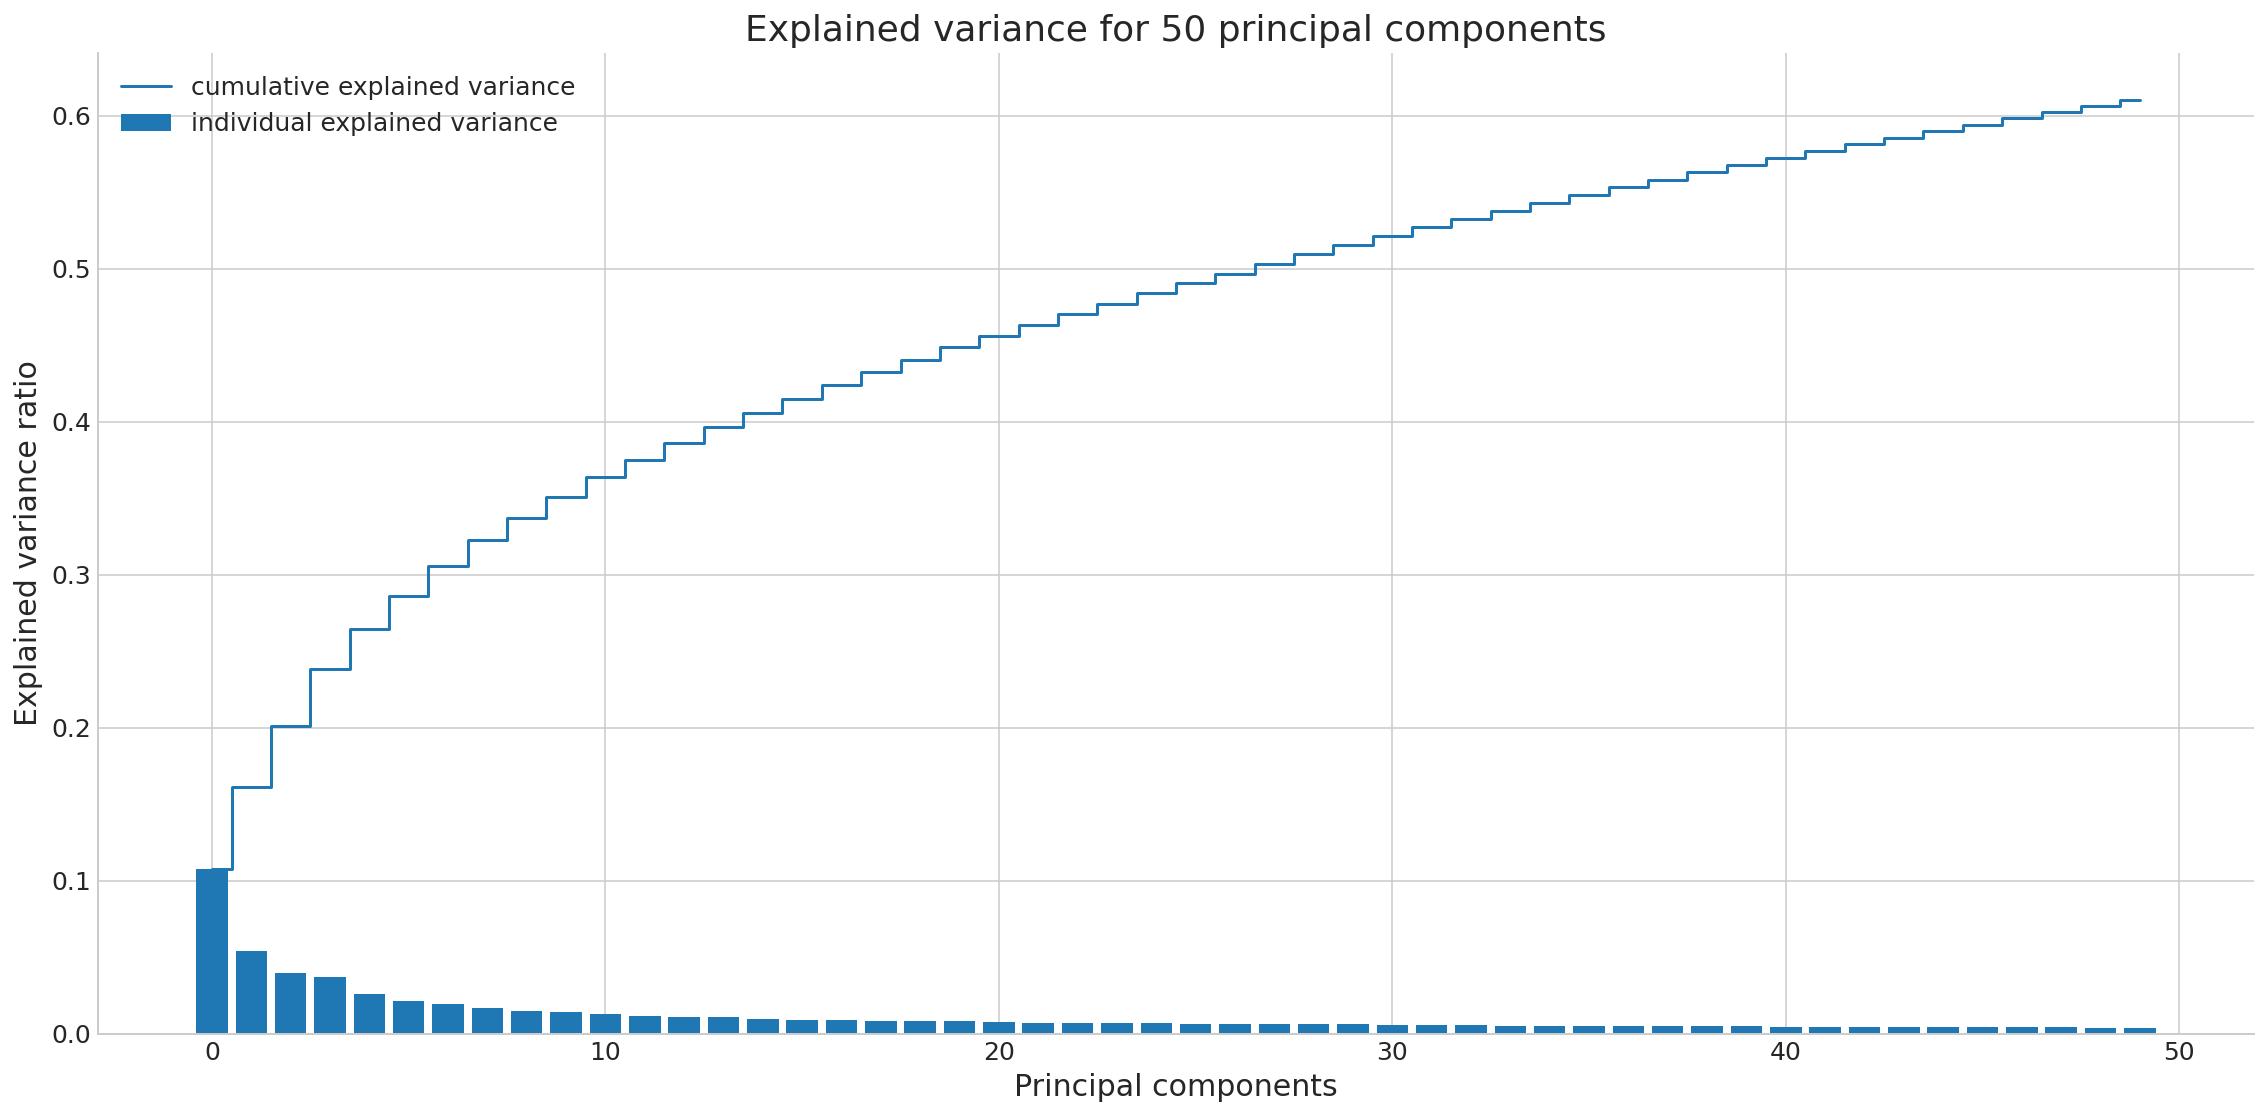

In [ ]:
"""
ex = pca_all.explained_variance_ratio_

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(16, 8))

    plt.bar(range(N_COMPS), ex, align='center',label='individual explained variance')
    plt.step(range(N_COMPS), np.cumsum(ex), where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.title("Explained variance for {} principal components".format(N_COMPS))
    plt.tight_layout()

"""


2-component PCA plot; not using

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

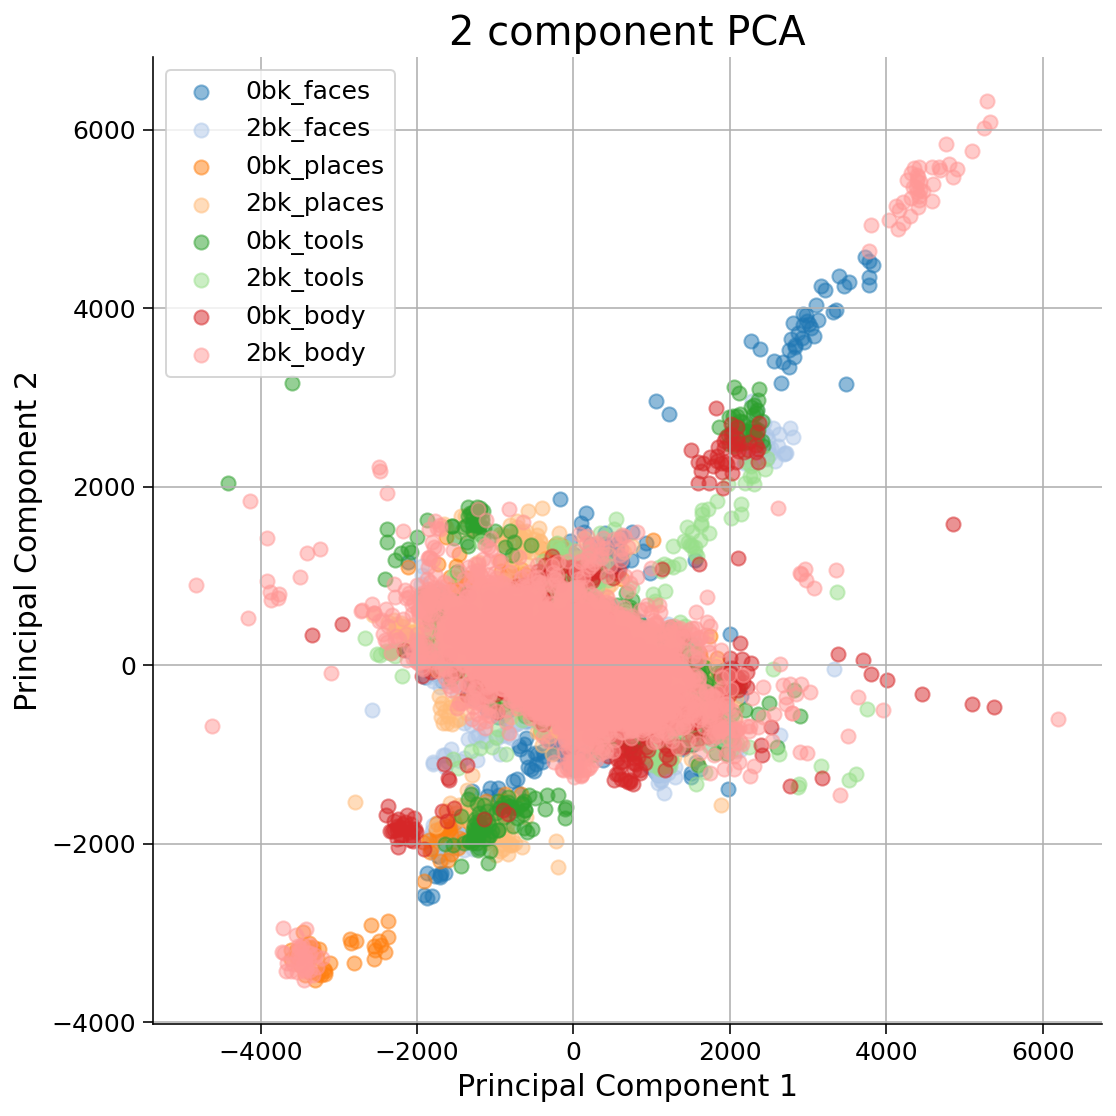

In [ ]:
"""
cmap=plt.cm.get_cmap(plt.cm.tab20,400)
n=1
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']
#colors = ['r', 'g', 'b', 'c', 'y', 'm']
for i, target in enumerate(targets):
    indicesToKeep = finalDf_all[N_COMPS] == target
    ax.scatter(finalDf_all.loc[indicesToKeep, 0]
               , finalDf_all.loc[indicesToKeep, 1]
               , c = cmap(n*i)
               , s = 50
               , alpha = .5);
ax.legend(targets);
ax.grid()
images_dir = '/content/gdrive/My Drive/nma-project-local'
#plt.savefig(f"{images_dir}/all_subjs_2comp_pca.png")
"""


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

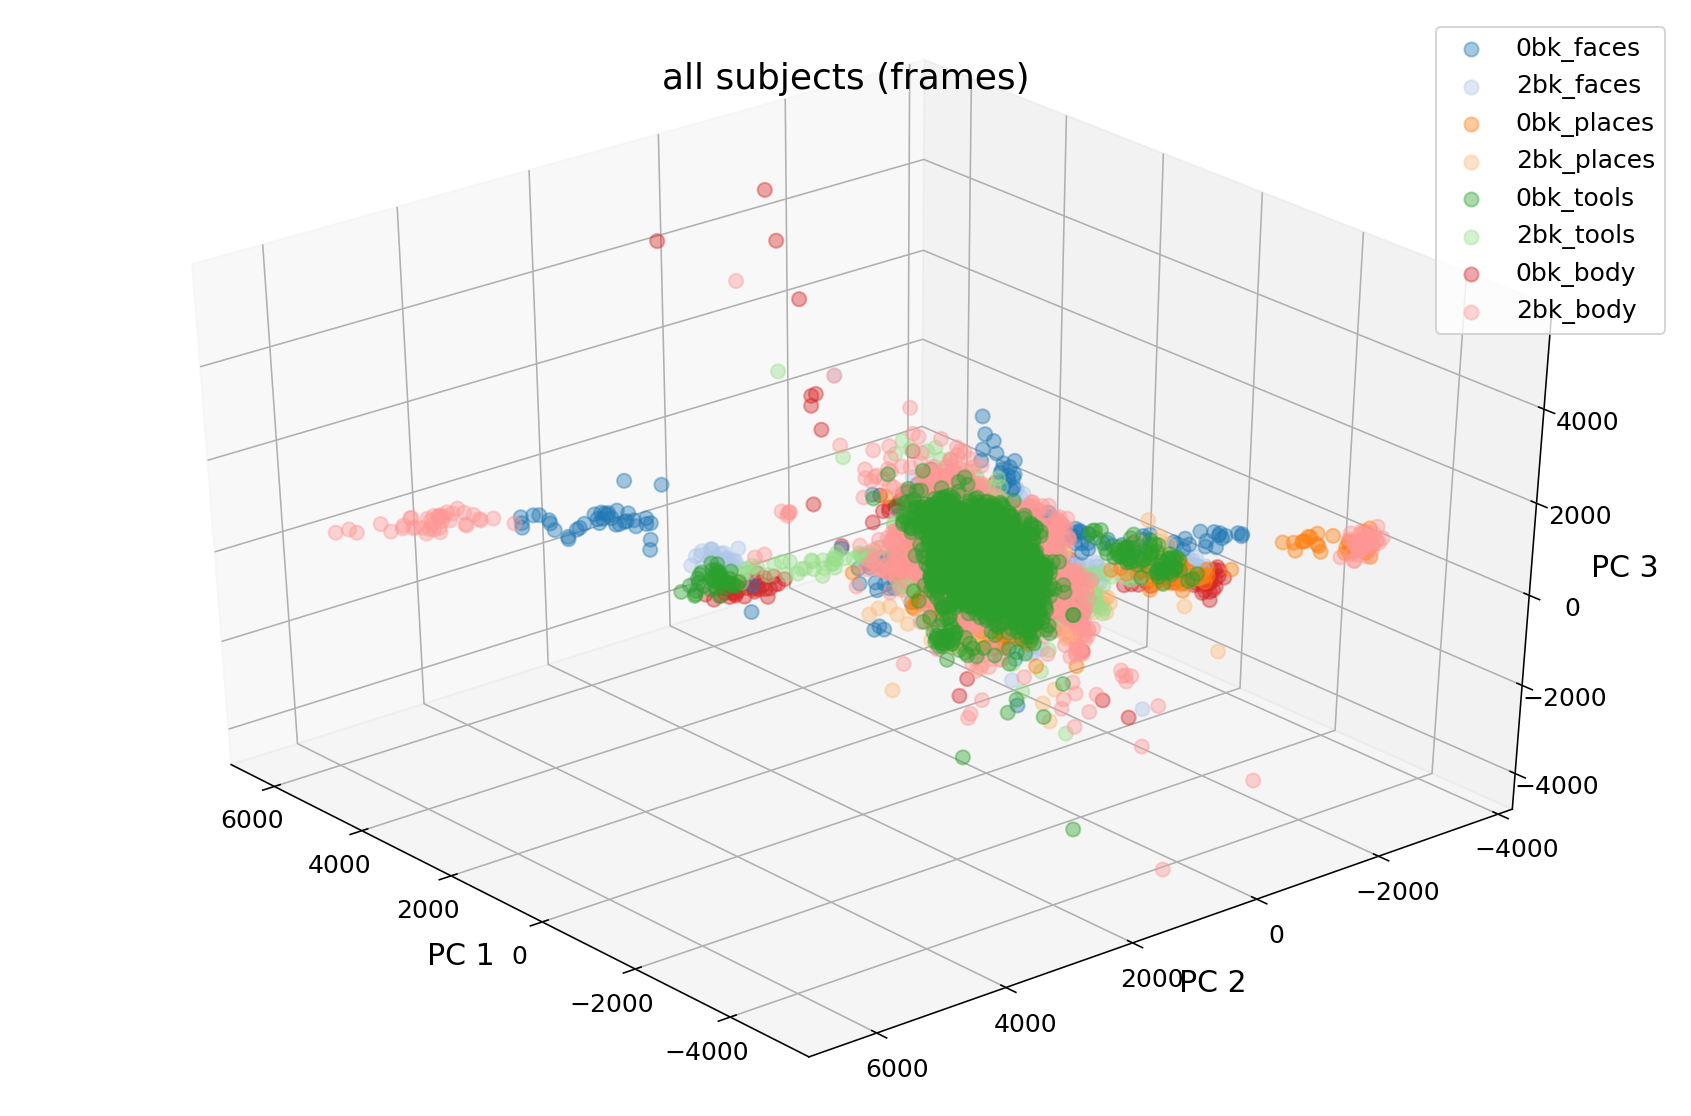

In [ ]:
"""
from mpl_toolkits.mplot3d import Axes3D
targets = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for i, target in enumerate(targets):
    indicesToKeep = finalDf_all[N_COMPS] == target
    ax.scatter(finalDf_all.loc[indicesToKeep, 0]
               , finalDf_all.loc[indicesToKeep, 1]
               , finalDf_all.loc[indicesToKeep, 2]
               , alpha = .4
               , c = cmap(n*i)
               , s = 50
               );
ax.view_init(35, 140)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title("all subjects (frames)")
ax.legend(targets);

plt.tight_layout()
#plt.savefig(f"{images_dir}/all_subjs_3d_pca_final.png")
"""

##  K-Means for clustering the higher dim PC's

In [ ]:
from sklearn.cluster import KMeans

#iterate up to 20 to figure out which # of clusters gives us best results
"""
within_cluster_sum_sqr = []
for i in range(1, 21):
  kmeans_pca=KMeans(n_clusters=i, random_state=43)
  kmeans_pca.fit(principalComponents_all)
  within_cluster_sum_sqr.append(kmeans_pca.inertia_)
  print(i)

plt.figure()

plt.plot(range(1, 21),within_cluster_sum_sqr, marker='o') # looks like 8 clusters is good
plt.xticks(range(1, 21))

"""

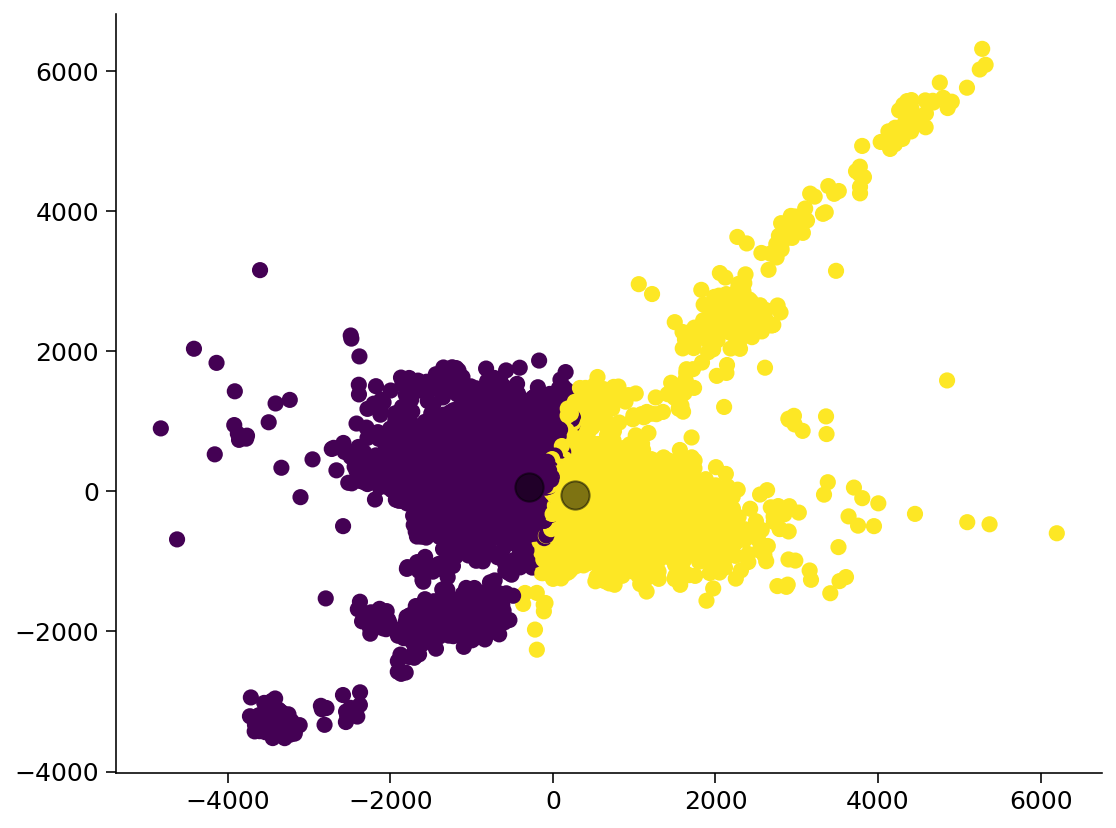

In [ ]:
# run kmeans with 8 clusters
"""
kmeans_pca = KMeans(n_clusters=2, random_state=43)
kmeans_pca.fit(principalComponents_all)

y_kmeans = kmeans_pca.predict(principalComponents_all)

plt.scatter(principalComponents_all[:, 0], principalComponents_all[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans_pca.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

"""

# t-SNE

In [ ]:
from sklearn.manifold import TSNE
import time

#use the first 50 components and then TSNE w that
pca_50 = PCA(n_components=50)
principalComponents50 = pca_50.fit_transform(X_all)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(principalComponents50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 105768 samples in 1.191s...


# Average plotting

In [ ]:
# load data from each run 
#(subject, task, condition, run, task_bold_timeseries):

X_run0 = np.ndarray((N_SUBJECTS*8,N_PARCELS))
X_run1 = np.ndarray((N_SUBJECTS*8,N_PARCELS))


labels_run0=[]
labels_run1=[]
subs=[]
for subject in subjects:
    timeser_0 = load_timeseries(subject=subject, name='wm')
    timeser_1 = load_timeseries(subject=subject, name='wm')

    X_run0[subject,:] = get_condition_bold(subject,'wm', '0bk_faces', run=0, task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS,:] = get_condition_bold(subject, 'wm', '2bk_faces', run=0,task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS*2,:] = get_condition_bold(subject,'wm', '0bk_places', run=0, task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS*3,:] = get_condition_bold(subject,'wm', '2bk_places', run=0, task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS*4,:] = get_condition_bold(subject,'wm', '0bk_tools', run=0, task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS*5,:] = get_condition_bold(subject, 'wm','2bk_tools', run=0,task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS*6,:] = get_condition_bold(subject,'wm', '0bk_body', run=0, task_bold_timeseries=timeser_0 )
    X_run0[subject+N_SUBJECTS*7,:] = get_condition_bold(subject,'wm', '2bk_body', run=0, task_bold_timeseries=timeser_0 )
    labels_run0.extend(['0bk_faces','2bk_faces','0bk_places','2bk_places','0bk_tools','2bk_tools','0bk_body','2bk_body'])
    subs.extend([subject]*8)

    X_run1[subject,:] = get_condition_bold(subject,'wm', '0bk_faces', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS,:] = get_condition_bold(subject, 'wm','2bk_faces', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS*2,:] = get_condition_bold(subject,'wm', '0bk_places', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS*3,:] = get_condition_bold(subject,'wm', '2bk_places', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS*4,:] = get_condition_bold(subject,'wm', '0bk_tools', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS*5,:] = get_condition_bold(subject, 'wm','2bk_tools', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS*6,:] = get_condition_bold(subject,'wm', '0bk_body', run=1, task_bold_timeseries=timeser_1)
    X_run1[subject+N_SUBJECTS*7,:] = get_condition_bold(subject,'wm', '2bk_body', run=1, task_bold_timeseries=timeser_1)
    labels_run1.extend(['0bk_faces','2bk_faces','0bk_places','2bk_places','0bk_tools','2bk_tools','0bk_body','2bk_body'])


# create labels 
y_one_run=np.hstack((np.zeros(339),np.ones(339*2),np.zeros(339)))

df_run0_avg = pd.DataFrame(X_run0, columns=['rgn_{}'.format(i) for i in range(0, 360)])
df_run1_avg = pd.DataFrame(X_run1, columns=['rgn_{}'.format(i) for i in range(0, 360)])


#labels_run0

In [ ]:
df_run0_avg['label'] = labels_run0
df_run0_avg['sub'] = subs
df_run1_avg['label'] = labels_run1
df_run1_avg['sub'] = subs

df_run0_avg.iloc[:,:-2].head()

,rgn_0,rgn_1,rgn_2,rgn_3,rgn_4,rgn_5,rgn_6,rgn_7,rgn_8,rgn_9,rgn_10,rgn_11,rgn_12,rgn_13,rgn_14,rgn_15,rgn_16,rgn_17,rgn_18,rgn_19,rgn_20,rgn_21,rgn_22,rgn_23,rgn_24,rgn_25,rgn_26,rgn_27,rgn_28,rgn_29,rgn_30,rgn_31,rgn_32,rgn_33,rgn_34,rgn_35,rgn_36,rgn_37,rgn_38,rgn_39,...,rgn_320,rgn_321,rgn_322,rgn_323,rgn_324,rgn_325,rgn_326,rgn_327,rgn_328,rgn_329,rgn_330,rgn_331,rgn_332,rgn_333,rgn_334,rgn_335,rgn_336,rgn_337,rgn_338,rgn_339,rgn_340,rgn_341,rgn_342,rgn_343,rgn_344,rgn_345,rgn_346,rgn_347,rgn_348,rgn_349,rgn_350,rgn_351,rgn_352,rgn_353,rgn_354,rgn_355,rgn_356,rgn_357,rgn_358,rgn_359
0,52.311757,11.227673,26.797930,56.980323,37.593903,39.533067,62.218594,31.560676,51.727599,45.457768,54.753833,30.170239,43.197341,34.461406,21.972650,20.624482,48.331643,65.734188,62.540399,0.544615,-4.706040,95.762699,11.739341,42.108756,33.981852,47.875575,20.212118,21.156570,4.908775,23.368547,47.671244,65.714169,63.131377,89.048452,8.697569,73.661783,17.309155,4.294017,15.026712,34.106192,...,29.189573,59.276144,25.188661,27.565436,28.322203,41.621159,12.388416,23.424553,31.749749,55.876049,24.934511,-6.352289,52.389706,13.117056,40.894701,37.340099,13.826648,47.020437,57.585850,-9.095802,79.913276,84.368756,55.766268,42.758150,43.213704,-130.237267,61.345432,2.237626,60.023742,52.308376,5.626762,32.117766,41.025793,66.686325,31.177221,120.355745,-21.678023,37.054397,26.959069,-16.490503
1,5.018560,-9.083916,17.117417,3.050676,12.328902,17.114802,21.792984,-5.795058,-39.056678,6.991949,-16.134152,-22.089035,28.834511,-45.847388,9.211320,21.271219,14.240817,53.354986,30.225873,18.310179,15.651208,11.783597,-15.743189,11.466300,-8.685643,9.063799,11.783533,-5.468777,10.118746,12.987711,-13.478689,-1.941709,-22.359772,23.062545,52.668642,-18.886769,-1.281045,17.422754,5.519316,6.273352,...,31.211671,17.069250,18.476386,30.355212,60.142767,30.282678,11.424729,27.481368,30.851859,27.082661,39.621664,52.402412,-19.872536,27.298898,43.526566,24.265502,8.337035,5.657062,27.980701,-27.864615,39.153390,43.078993,31.562868,5.572515,77.666255,133.247104,49.310883,77.178234,20.260874,93.214568,106.138386,21.722697,25.248129,33.205326,24.188230,59.056524,25.963548,27.019791,32.893504,37.401387
2,0.576030,4.243383,-15.200433,15.161273,20.401443,24.554872,33.425016,19.459601,0.240484,15.274606,-4.276866,5.618965,-6.285066,26.892972,15.097989,-10.016036,-19.859649,69.181649,11.726847,6.094021,29.040623,66.478046,1.026783,50.458898,16.669324,34.101292,-0.246406,10.749077,-1.125328,8.210693,-5.453067,22.347160,30.715537,37.994302,-3.842602,36.497911,23.064773,19.571206,-5.335117,49.601728,...,32.061561,23.970389,1.573506,23.061774,29.240165,22.639449,31.213557,29.760794,29.585951,41.340416,28.849603,-2.837926,17.445337,6.917455,47.633827,31.443014,1.489111,3.833675,19.435014,11.807768,39.876201,22.411244,29.646078,-77.652707,-14.852484,-300.501406,61.783343,16.413694,33.685280,52.495632,26.840646,7.973764,25.591301,49.128218,15.934089,30.816524,48.467202,33.808072,48.804653,52.403457
3,0.976942,-31.517670,86.857398,23.453732,34.179031,10.157379,-109.957854,107.251628,67.255763,99.888579,22.478507,22.274828,58.837588,-14.614378,92.501842,24.292021,43.392458,-20.831852,-10.798974,-69.852746,34.383930,14.586600,-1.438615,55.372929,-10.767588,130.569706,132.784298,-10.303244,59.335506,109.700969,-26.587255,91.813390,-45.209858,5.010845,164.865052,144.290870,142.560389,90.449896,131.293179,156.399816,...,18.845964,55.016486,50.546914,93.910412,57.954917,30.404482,73.415210,110.371481,94.185005,51.365622,73.081747,26.976741,0.012688,24.770845,113.402488,108.667113,-39.056600,18.956980,31.635119,-31.175594,140.143685,102.943932,34.619981,227.707685,211.200990,303.100218,144.107369,0.206971,138.075081,413.698557,132.537892,280.051136,72.617170,26.482640,56.171052,86.449478,61.839354,79.825698,-18.855802,162.469478
4,-2.907654,77.083343,16.388186,10.882792,17.076372,38.101216,29.867673,29.705168,66.239586,35.217987,66.703894,36.427844,10.836163,-5.386895,40.187312,

In [ ]:
n_PCs=50

X_avg_0 = np.matrix(df_run0_avg.iloc[:,:-2])


pca_avg = PCA(n_components=50)

pca_avg_result_0 = pca_avg.fit_transform(X_avg_0)

pca_avg.explained_variance_ratio_



array([0.26180397, 0.1316902 , 0.08194684, 0.04222926, 0.03423831,
       0.02237955, 0.01942483, 0.01597798, 0.01439496, 0.01291815,
       0.01201609, 0.01154255, 0.00971408, 0.00880959, 0.00824445,
       0.00804195, 0.00722303, 0.00701415, 0.00647443, 0.00642962,
       0.00610228, 0.00554964, 0.00527835, 0.00524521, 0.00502719,
       0.00498779, 0.00455757, 0.00446046, 0.00434066, 0.00417017,
       0.00401135, 0.00392068, 0.00366775, 0.00356133, 0.0035295 ,
       0.00344904, 0.0033769 , 0.00329185, 0.00319101, 0.00310277,
       0.00303042, 0.00297579, 0.00286501, 0.00281434, 0.00273274,
       0.0026024 , 0.0025135 , 0.0024833 , 0.00245138, 0.00239307])

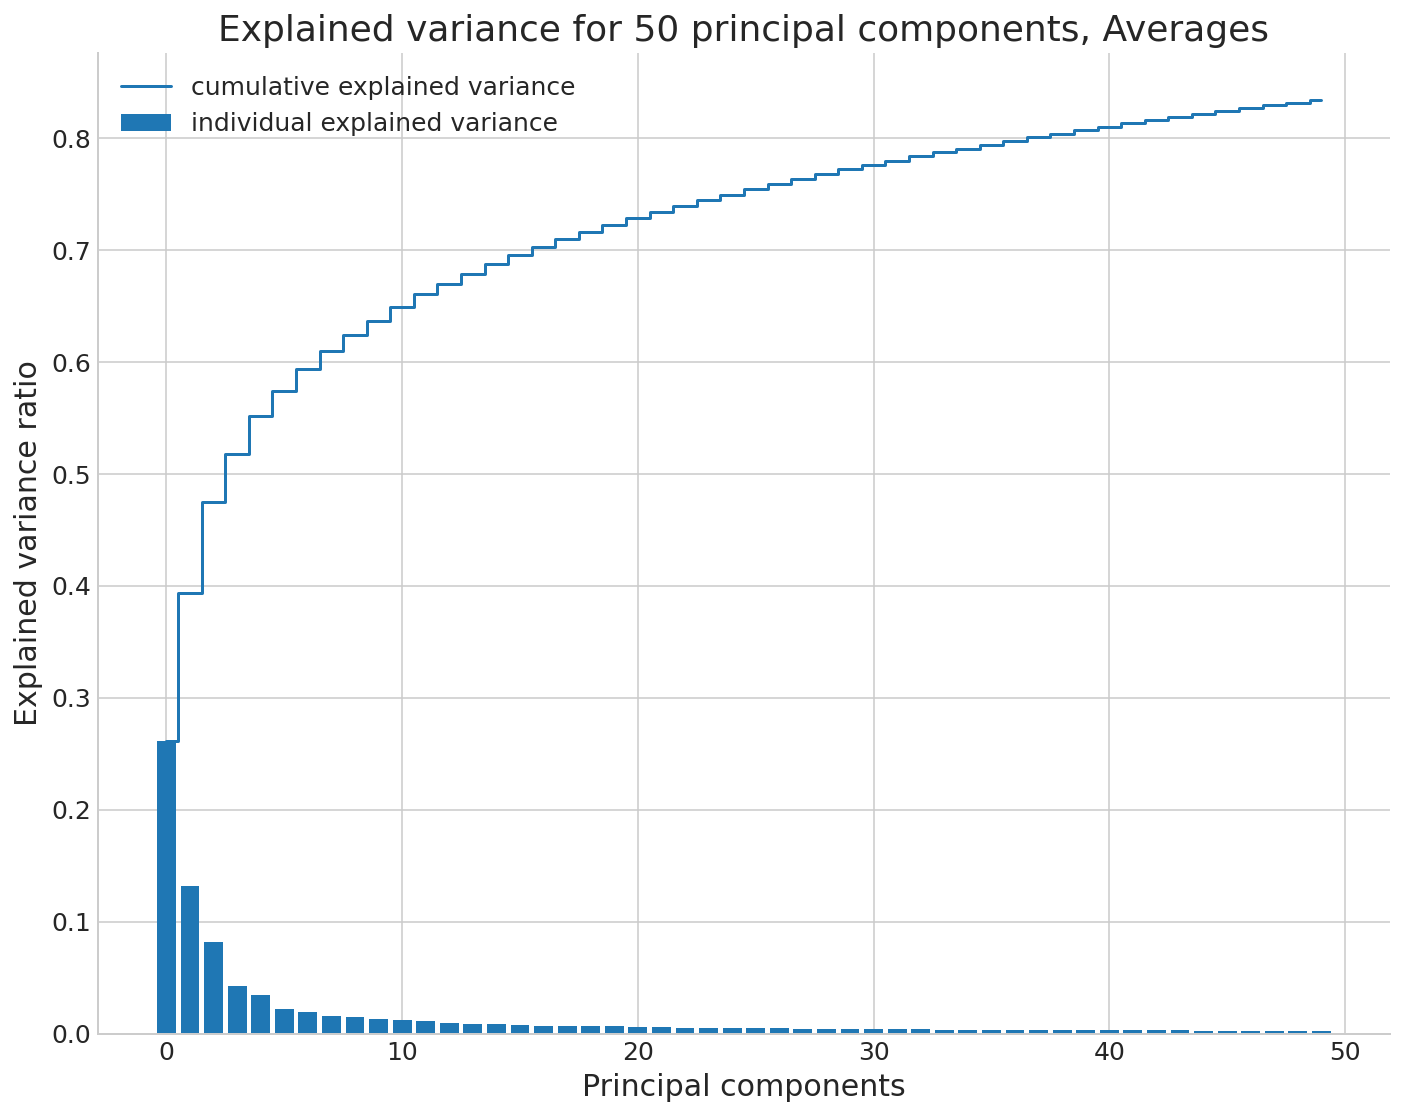

In [ ]:
expl = pca_avg.explained_variance_ratio_

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,8))

    plt.bar(range(50), expl, align='center',label='individual explained variance')
    plt.step(range(50), np.cumsum(expl), where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.title("Explained variance for {} principal components, Averages".format(50))
    plt.tight_layout()

    plt.savefig(f"{images_dir}/explained_var_final.png")
    

In [ ]:
label_dict={'0bk_faces':0, 
            '2bk_faces':1, 
            '0bk_places':2, 
            '2bk_places':3,
            '0bk_tools':4, 
            '2bk_tools':5,
            '0bk_body':6, 
            '2bk_body':7
}

label_dict['2bk_body']

7

In [ ]:


pc_avg_df = pd.DataFrame(data=pca_avg_result_0, columns=['PC_{}'.format(i) for i in range(0, n_PCs)])
pc_avg_df['labels'] = labels_run0

pc_avg_df['labels'] = pc_avg_df['labels'].apply(str)


pc_avg_df.iloc[:,50] == '2bk_faces'

indices = pc_avg_df.iloc[:,-1] == '2bk_faces'
#pc_avg_df.iloc[indices, 0]
type(indices)
indices

pc_avg_df.iloc[:,-1].values


array(['0bk_faces', '2bk_faces', '0bk_places', ..., '2bk_tools',
       '0bk_body', '2bk_body'], dtype=object)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

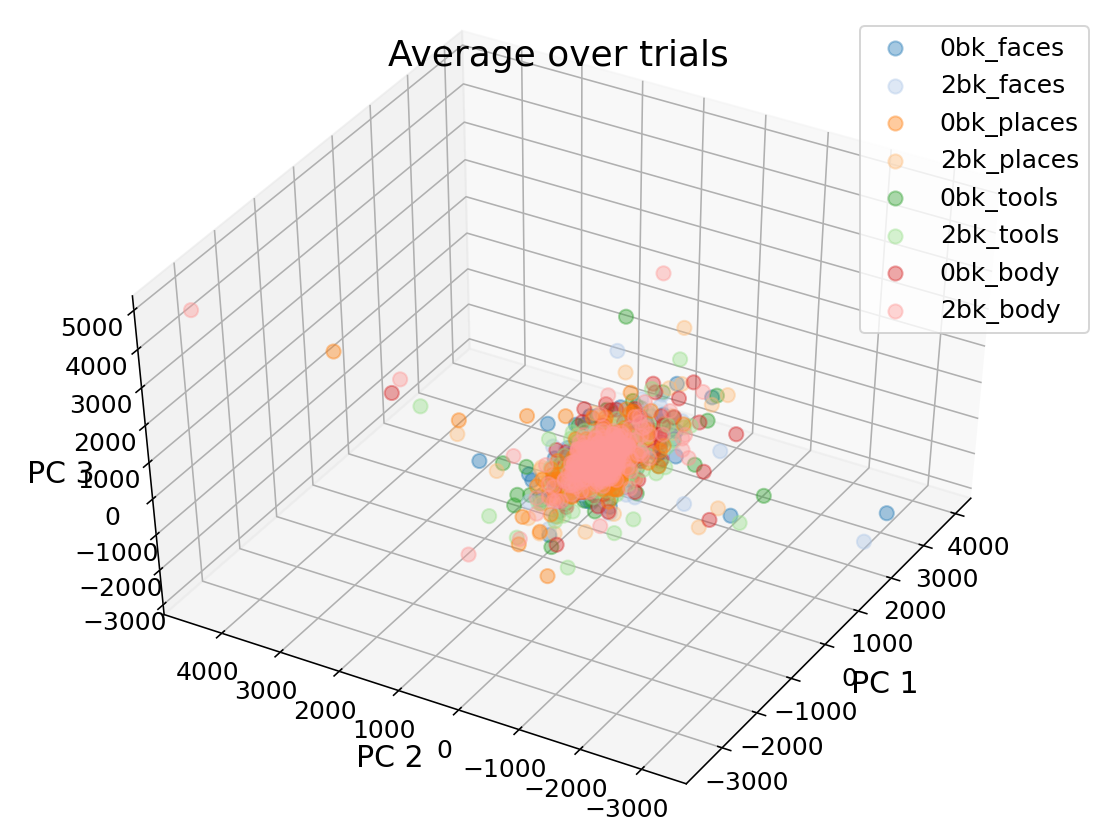

In [ ]:
# pc_avg_df.iloc[:,:-1]
cmap=plt.cm.get_cmap(plt.cm.tab20,400)

from mpl_toolkits.mplot3d import Axes3D
targets = ['0bk_faces', '2bk_faces', '0bk_places', '2bk_places','0bk_tools', '2bk_tools','0bk_body', '2bk_body']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, target in enumerate(targets):
    indicesToKeep = pc_avg_df.iloc[:,-1].values == target
    ax.scatter(pc_avg_df.iloc[indicesToKeep, 0]
               , pc_avg_df.iloc[indicesToKeep, 1]
               , pc_avg_df.iloc[indicesToKeep, 2]
               , c = cmap(i)
               , s = 50
               , alpha=.4);
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title("Average over trials")
ax.view_init(45, 210)
ax.legend(targets);

plt.savefig(f"{images_dir}/avg_3d_pca_final.png")